# Testing LPP MEG data's validity


## Purpose
The purpose of this notebook is to investigate the correct epoching and trigger time matching for the MEG recordings of the LPP paradigm.

## Methodology
- For each subject, get the 9 epochs corresponding to the first trigger (start of audio).
- Average the MEG channels to see if there's an evoked response to the first audio stimuli

## WIP - improvements
Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [22]:
# Imports

import mne
import mne_bids
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib
from joblib import Parallel, delayed
matplotlib.use("Agg")
mne.set_log_level(False)
import time
import os

%matplotlib inline

# Parameter definition


In [77]:
bids = "/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all"
bids_raw = "/home/is153802/workspace_LPP/data/MEG/LPP/LPP_bids"


# Data import
We retrieve all the required data for the analysis.

In [5]:
subjects = pd.read_csv(bids + "/participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values
subjects = np.delete(subjects,subjects.shape[0]-1)
print(subjects)

['180131' '180517' '181017' '190506' '190513' '190611' '190621' '190715'
 '190717' '220628' '220707']


Rename the fif files that have been preprocessed to the BIDS standart (*_raw.fif to *_meg.fif)

In [29]:
# Done already for the current batch of filtered data by the MNE BIDS Pipeline
"""
for subject in subjects:
    subj_path = os.path.join(bids,'sub-'+subject,'ses-01/meg')
    for filename in os.listdir(subj_path):
        infilename = os.path.join(subj_path,filename)
        if not os.path.isfile(infilename): continue
        oldbase = os.path.splitext(filename)
        newname = infilename.replace('raw.fif', 'meg.fif')
        output = os.rename(infilename, newname)
        
"""

Add the needed files (events, headposition & co) to the newly generated post-processing folders (done manually; faster than doing a regex)

# Data processing


## Trying to use the first trigger to see the evoked response

### For one subject: testing the STIM channels & triggers

In [87]:
bids_path = mne_bids.BIDSPath(
                subject='220707',
                session='01',
                task='rest',
                datatype="meg",
                root=bids_raw,
                run = '01'
            )

print(bids_path)
raw_bids = mne_bids.read_raw_bids(bids_path)

raw_bids.load_data()

/home/is153802/workspace_LPP/data/MEG/LPP/LPP_bids/sub-220707/ses-01/meg/sub-220707_ses-01_task-rest_run-01_meg.fif


/tmp/ipykernel_352459/790857006.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw_bids = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/790857006.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw_bids = mne_bids.read_raw_bids(bids_path)


<Raw | sub-220707_ses-01_task-rest_run-01_meg.fif, 346 x 633000 (633.0 s), ~1.64 GB, data loaded>

In [88]:
raw_ = raw_bids.copy().pick_types(meg=False, stim=True)

In [106]:
events = mne.find_events(raw_, stim_channel='STI101')
print(events)

[[153674      0      1]
 [156933      0    128]
 [157303      0    128]
 ...
 [764086      0    128]
 [764247      0    128]
 [767412      0      1]]


Calculating the total length between the two STOP / START triggers

In [99]:
length_trigger = (events[-2,0] - events[1,0])/1000

In [100]:
LENGTH_WAV_FILE = 607.181

In [104]:
difference = abs(length_trigger - LENGTH_WAV_FILE)
print(f'Difference between .wav length and start / stop trigger recorded is {difference*1000} ms')

Difference between .wav length and start / stop trigger recorded is 132.9999999999245 ms


Checking the timestamp of the first word onset:
First word onset in the events.tsv (3.05s) is in theory equal to (sample_1 - sample_0)/fsamp

In [111]:
first_onset = 3.05

diff_triggers = (events[1][0] - events[0][0])/1000

print(diff_triggers)

print(f'Difference between first word onset from events.tsv and in the recording is {1000*abs(first_onset-diff_triggers)} ms')

3.259
Difference between first word onset from events.tsv and in the recording is 209.00000000000009 ms


In [112]:
first_onset = 3.05
second_onset = 3.42
onset_diff = second_onset - first_onset

diff_triggers = (events[2][0] - events[1][0])/1000

print(f'Difference between first and second word onset (tsv vs STIM) {1000*abs(onset_diff-diff_triggers)} ms')

Difference between first and second word onset (tsv vs STIM) 1.1102230246251565e-13 ms


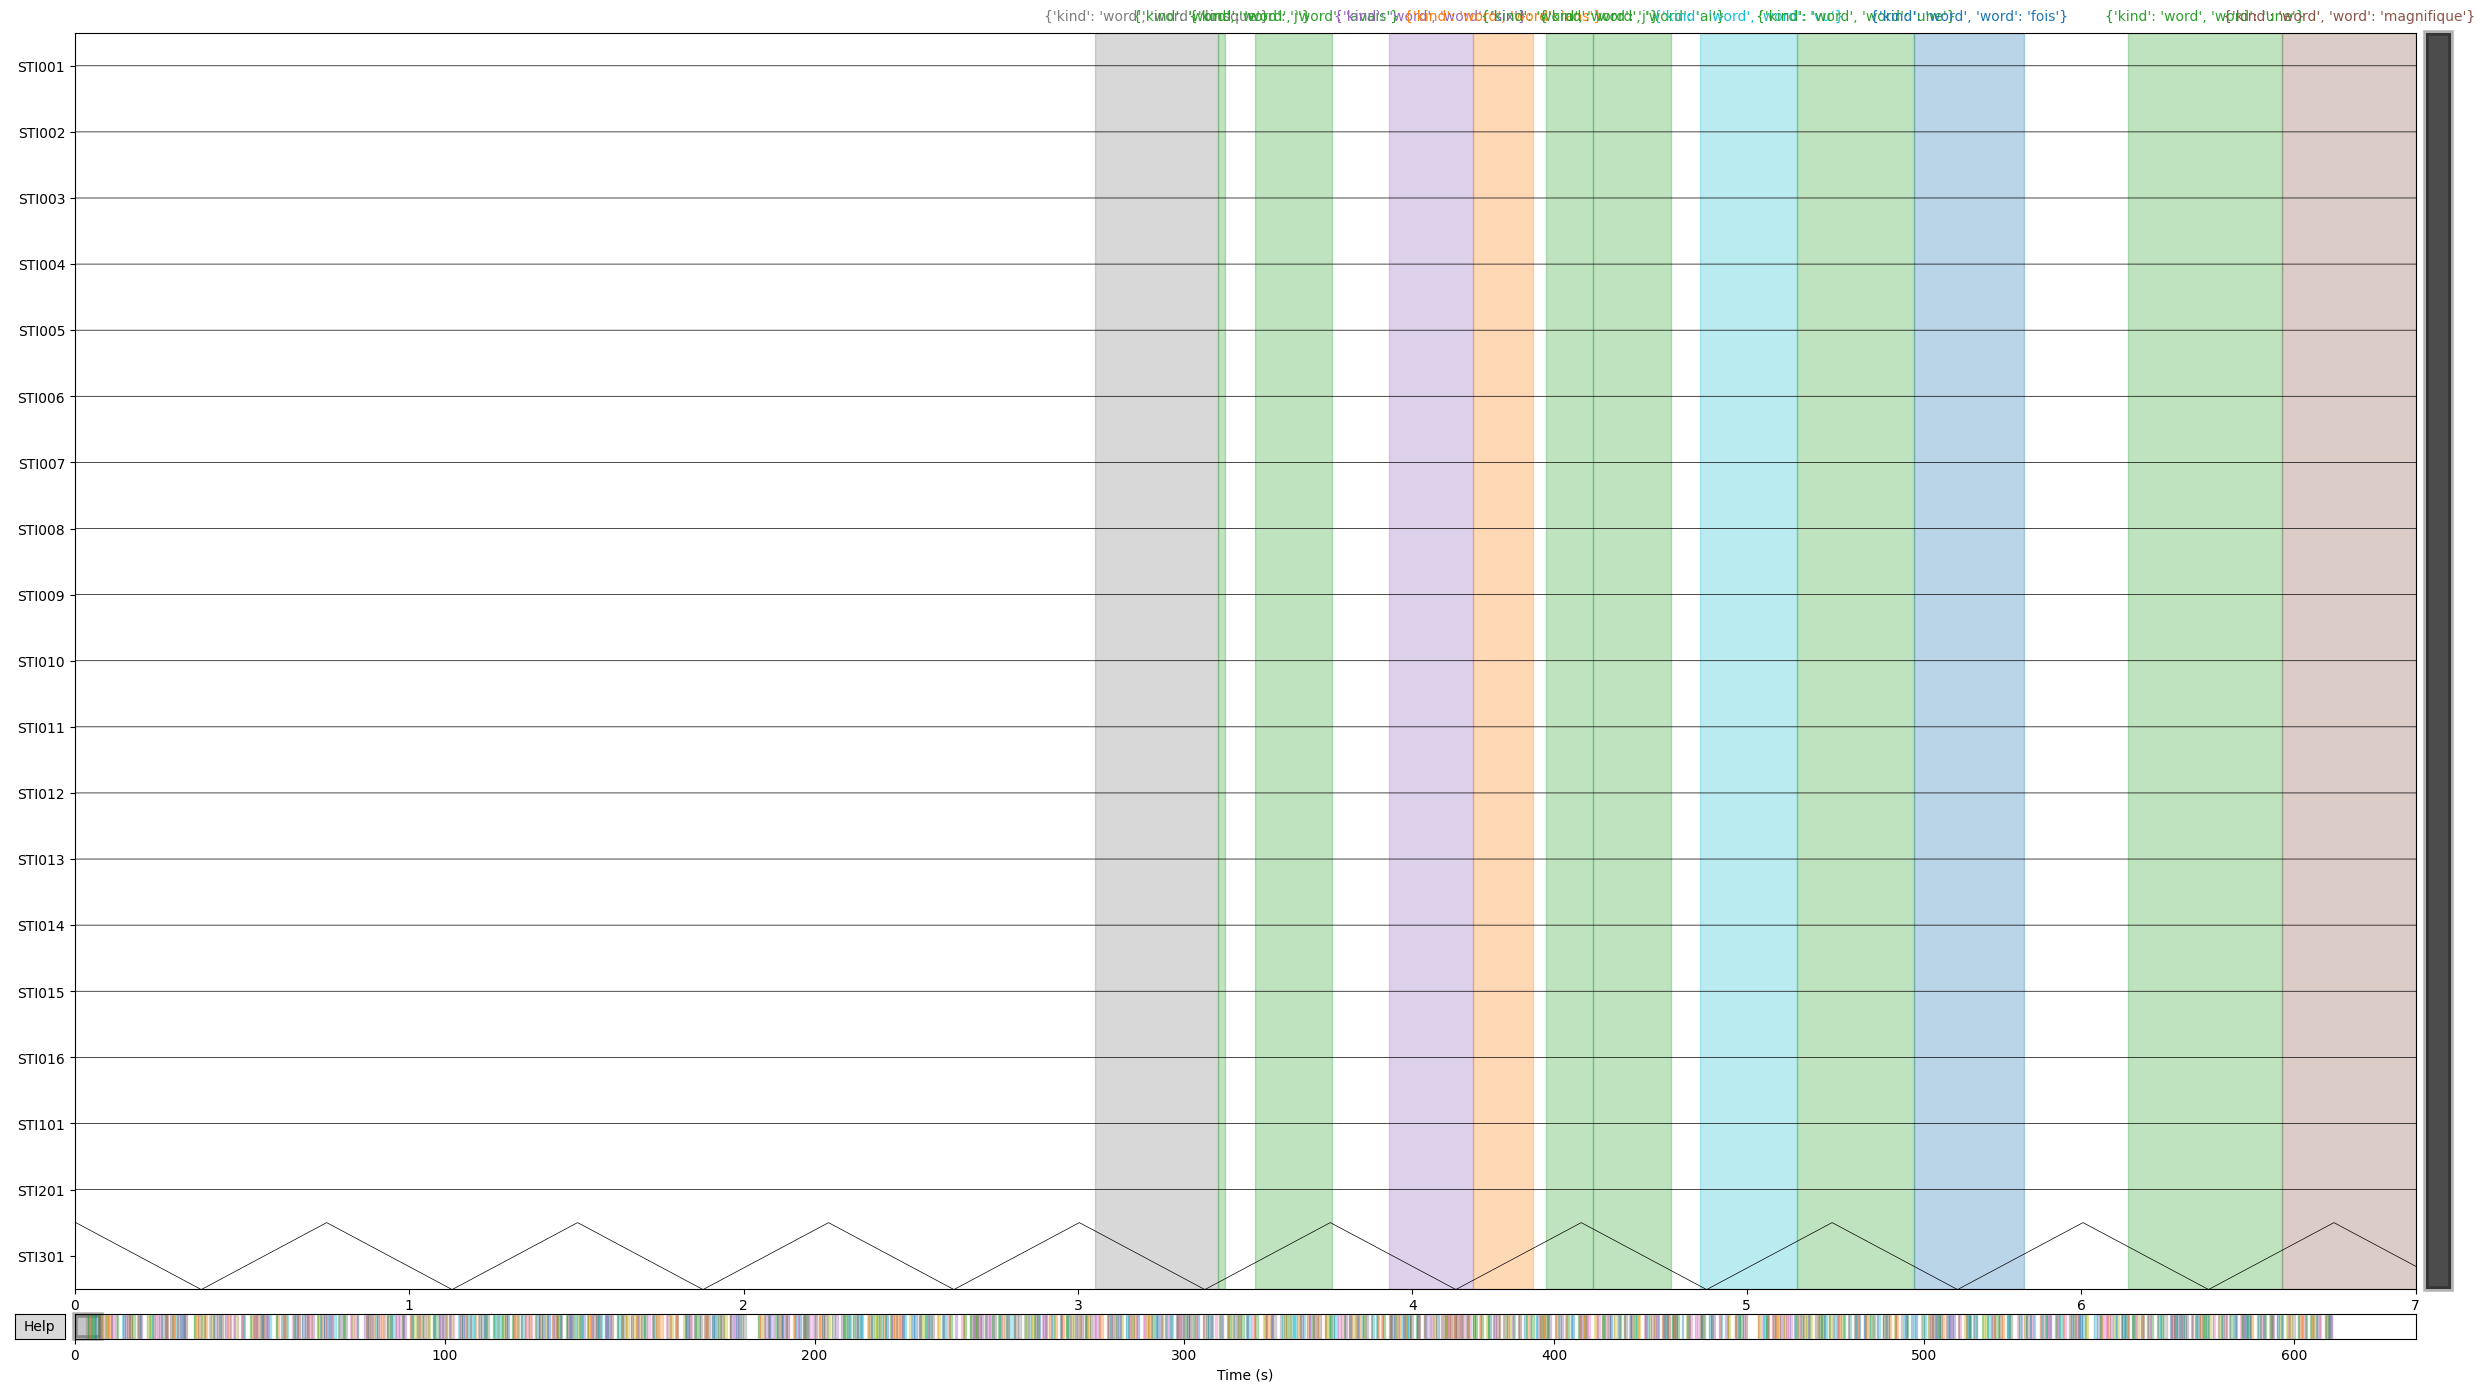

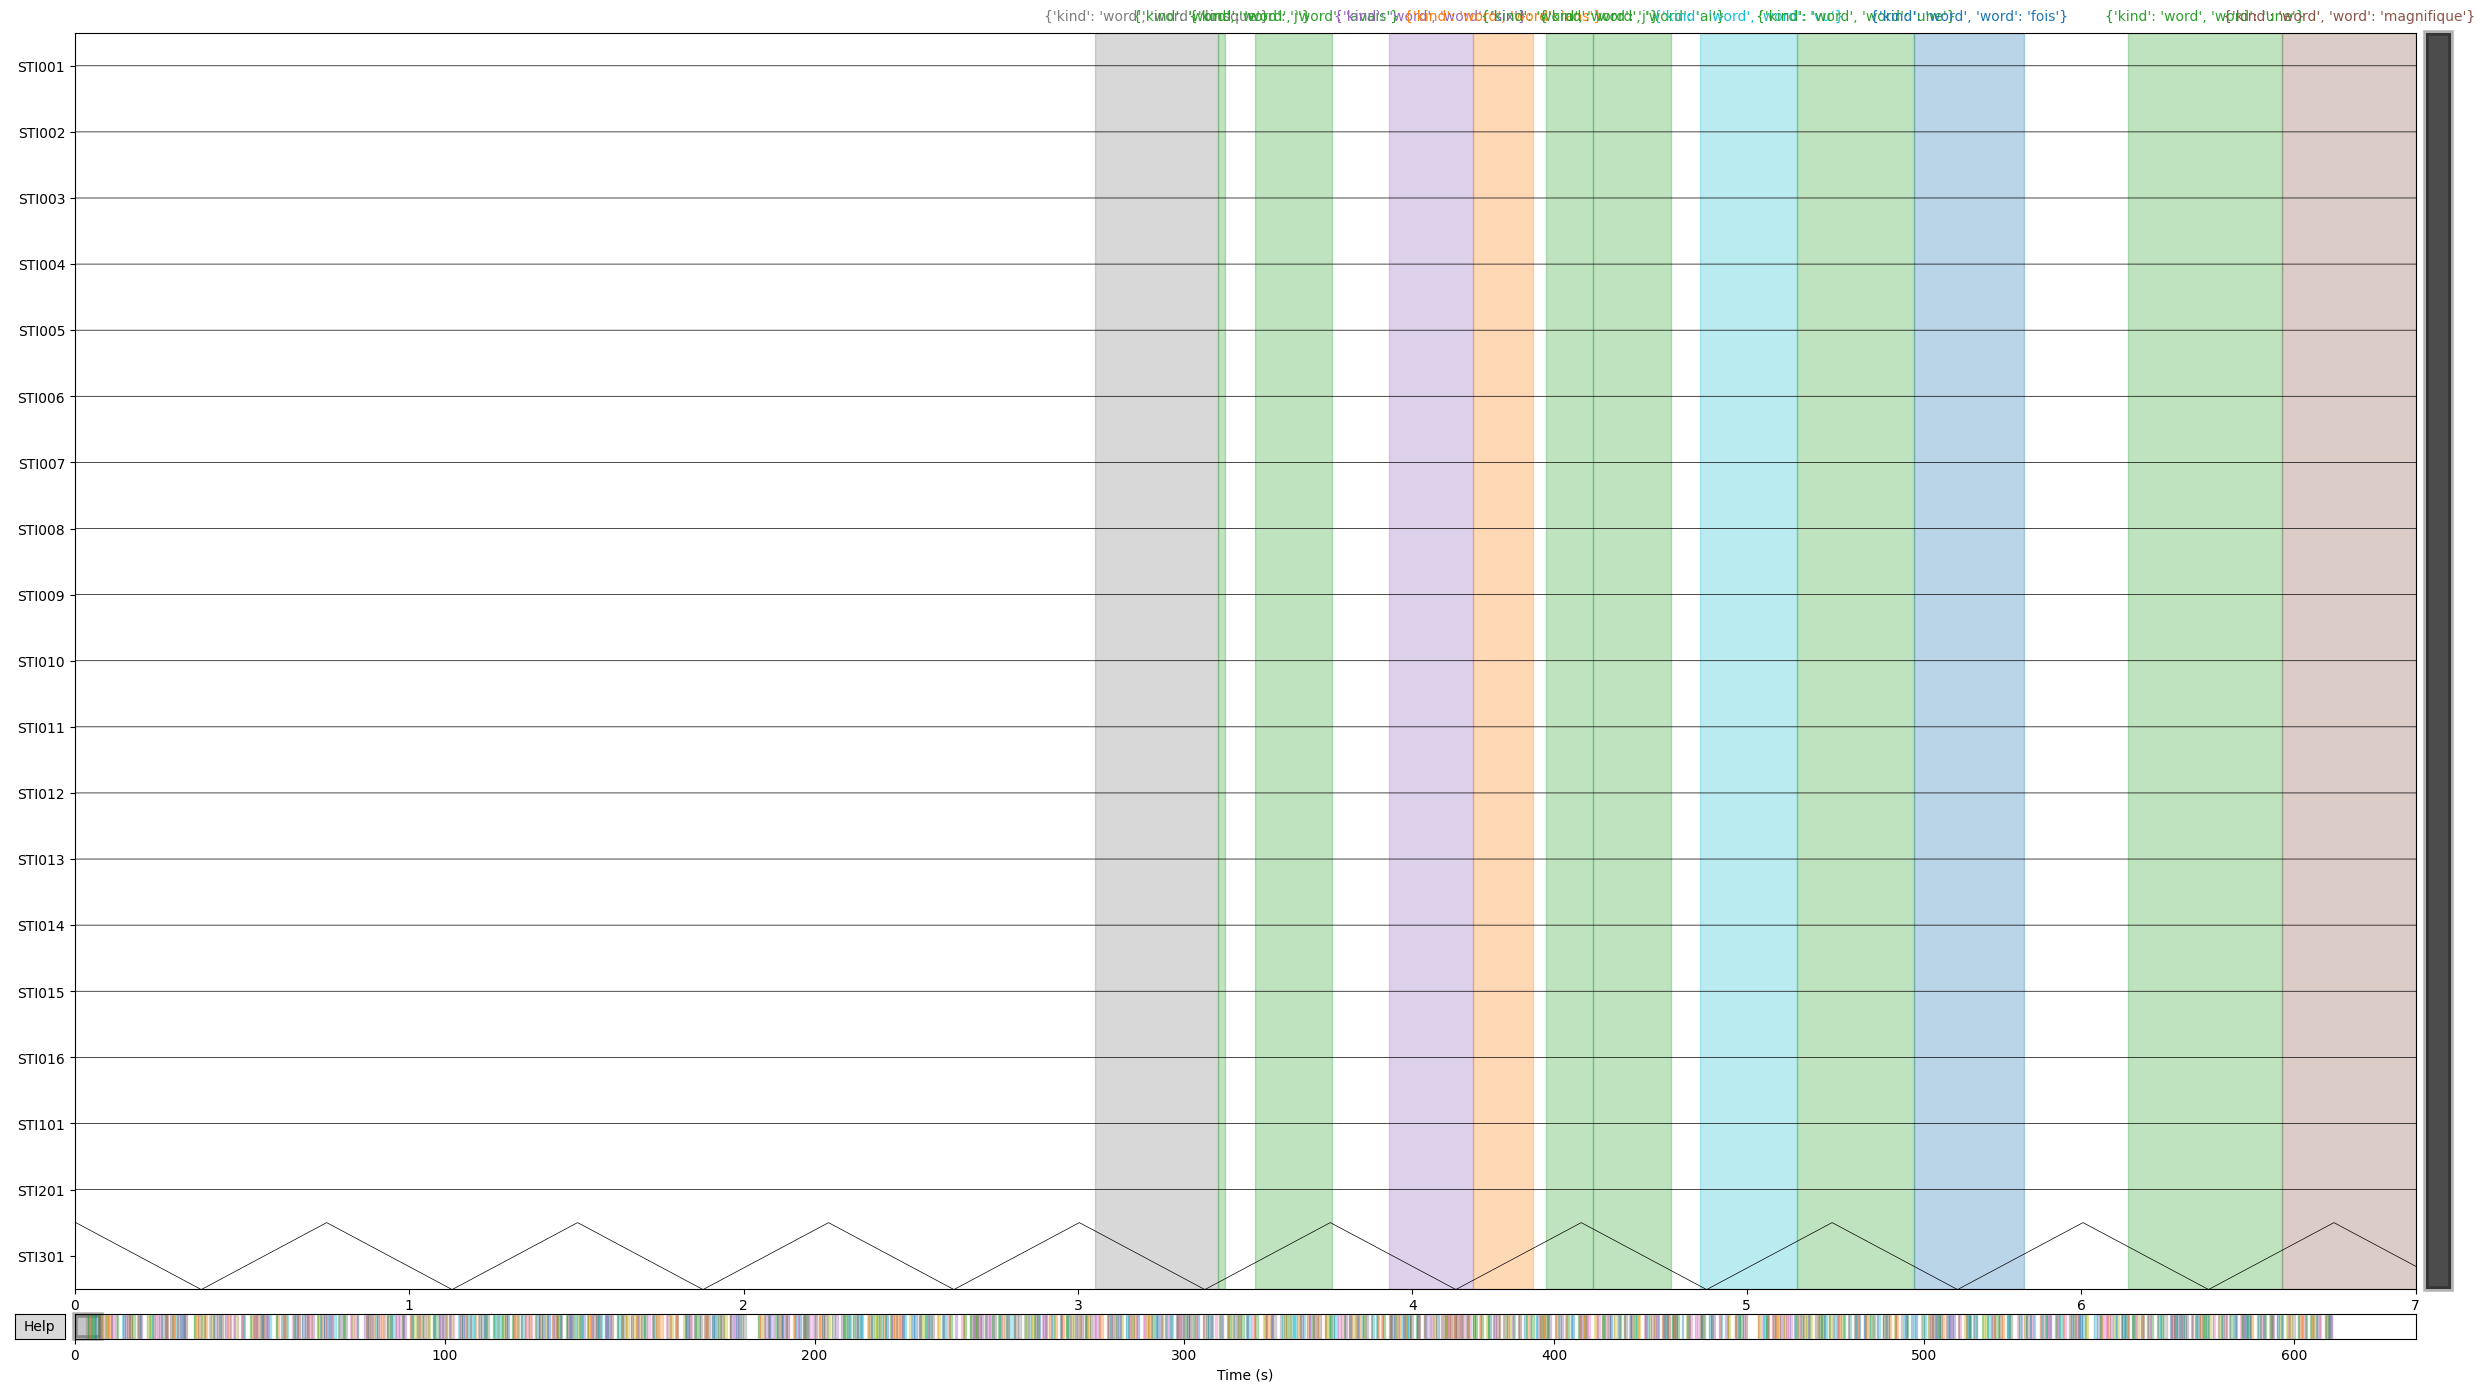

In [91]:
raw_.plot(start=0, duration=7)

In [71]:
bids_path = mne_bids.BIDSPath(
                subject='220707',
                session='01',
                task='rest',
                datatype="meg",
                root=bids,
                run = '01',
                processing = "sss"
            )

print(bids_path)
raw = mne_bids.read_raw_bids(bids_path)

raw = raw.pick_types(
    meg=True, misc=False, eeg=False, eog=False, ecg=False
)

raw.load_data().filter(0.5, 30.0, n_jobs=1)

/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-220707/ses-01/meg/sub-220707_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/926989393.py:12: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/926989393.py:12: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)


<Raw | sub-220707_ses-01_task-rest_run-01_proc-sss_meg.fif, 306 x 633000 (633.0 s), ~1.45 GB, data loaded>

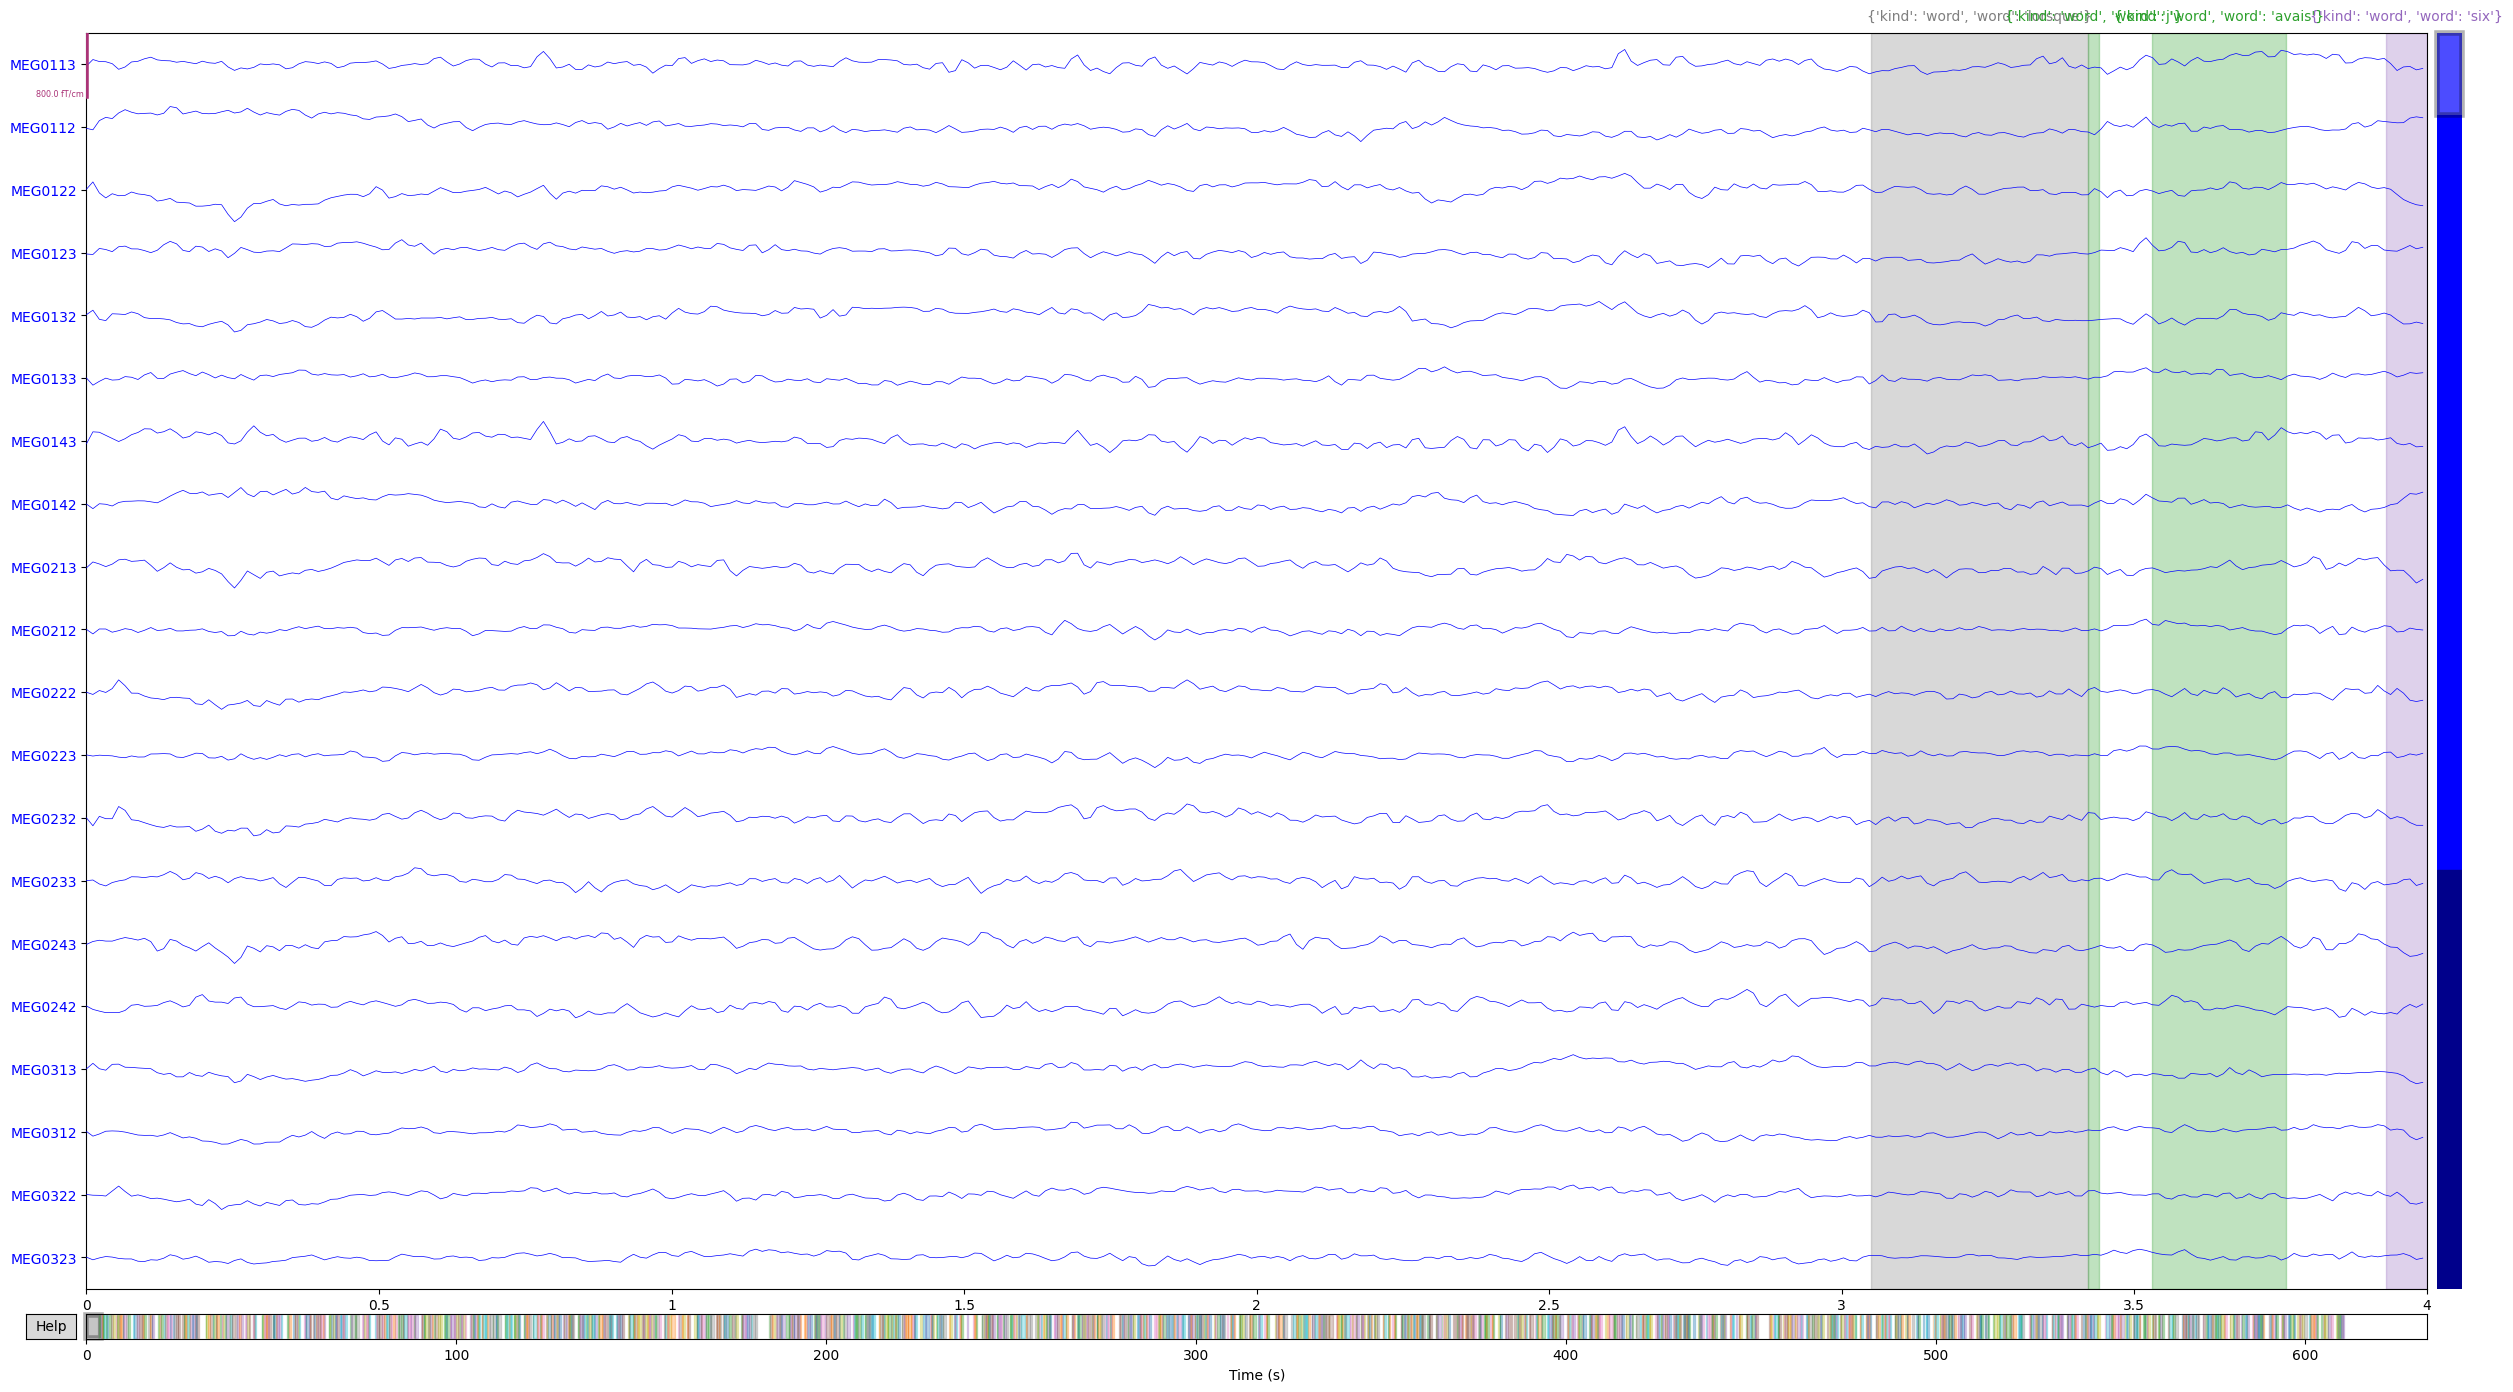

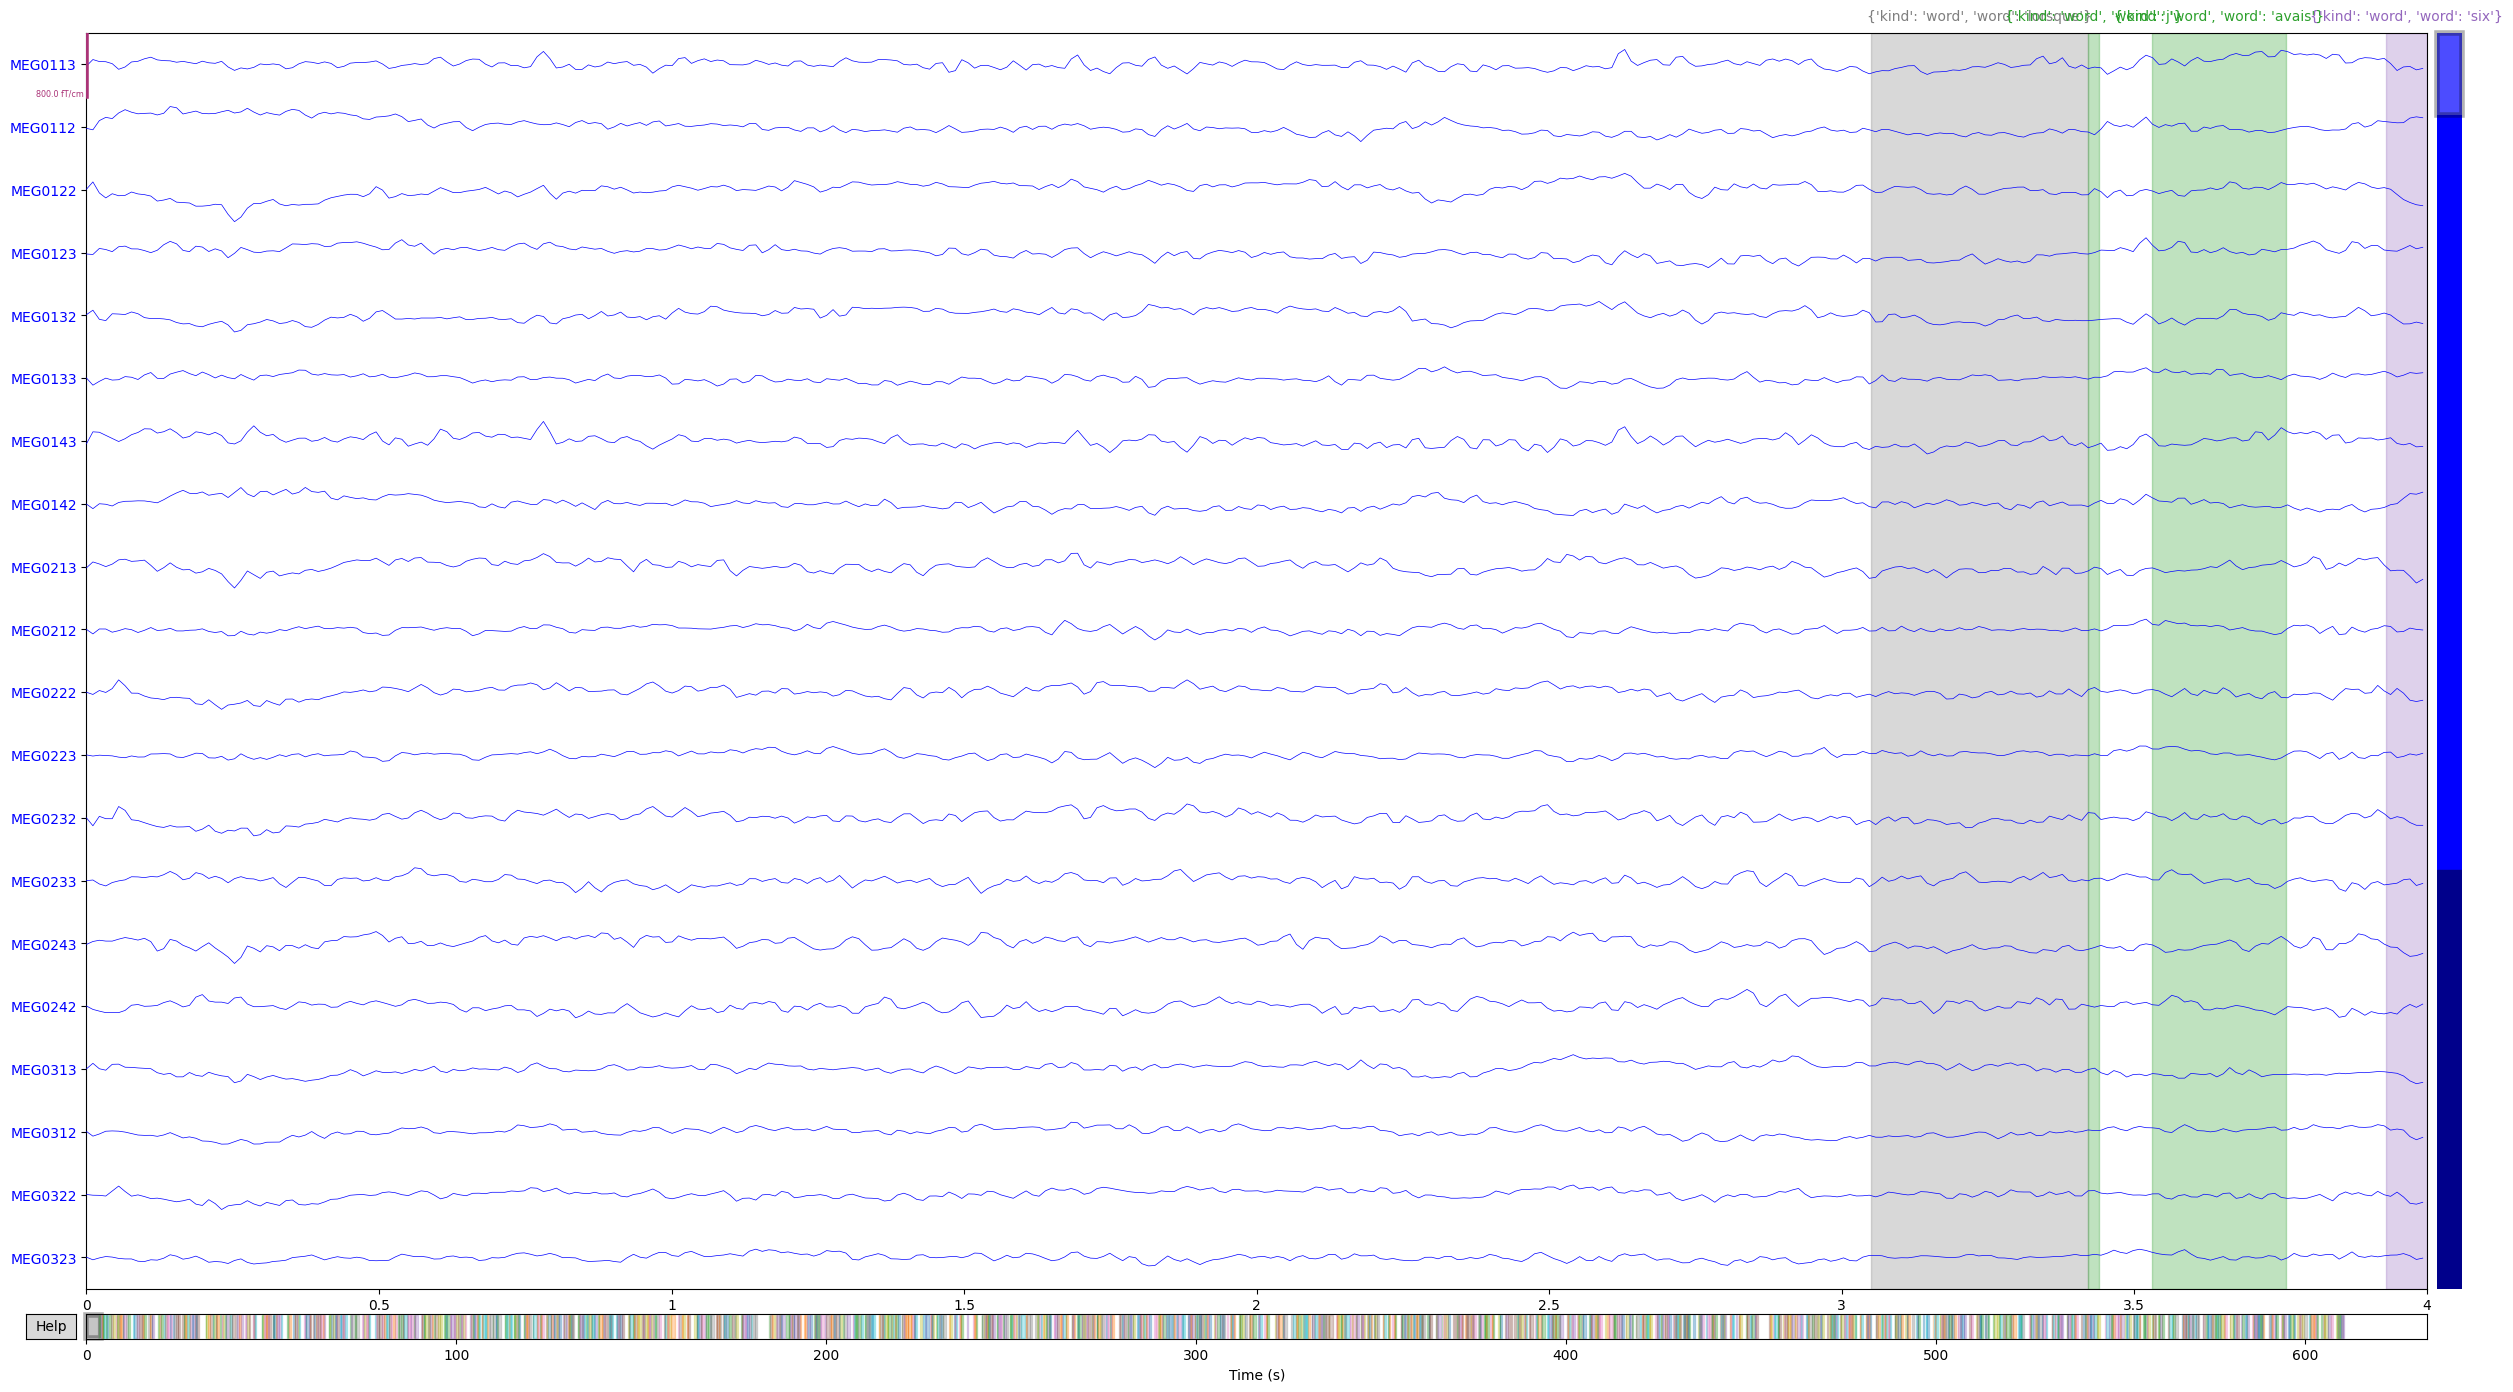

In [75]:
raw.plot(start = 0, duration = 4)

In [146]:
def _get_epochs(subject):
    all_epochs = list()
    for session in range(1,2):
        for run in range(1,2):
            task = 'rest'
            print(".", end="")
            bids_path = mne_bids.BIDSPath(
                subject=subject,
                session='0'+str(session),
                task=str(task),
                datatype="meg",
                root=bids,
                run = run,
                processing = "sss"
            )
            
            try:
                print(bids_path)
                raw = mne_bids.read_raw_bids(bids_path)
            except FileNotFoundError:
                print(f"missing, \nsubject:{subject}\nsession: {session}\ntask: {task}\nrun: {run}")
                continue
            raw = raw.pick_types(
                meg=True, misc=False, eeg=False, eog=False, ecg=False
            )

            raw.load_data().filter(0.5, 30.0, n_jobs=1)
            
            meta = list()
            # print(f"\n\n annot: {raw.annotations}\n\n")
            for annot in raw.annotations:
                try:
                    a = annot.pop("description")
                    d = eval(a)
                except:
                    print(f"eval error: {a}")
                    continue
                # print(f"\n\n d: {d}\n\n")
                for k, v in annot.items():
                    assert k not in d.keys()
                    d[k] = v
                meta.append(d)
            meta = pd.DataFrame(meta)
            meta["intercept"] = 1.0

            # segment on first event
            events = np.c_[
                meta.onset[0] * raw.info["sfreq"], np.ones((1, 2))
            ].astype(int)

            epochs = mne.Epochs(
                raw,
                events,
                tmin=-1.0,
                tmax=1.0,
                decim=10,
                baseline=(-1.0, 0.0),
                metadata=meta.head(1),
                preload=True,
                event_repeated="drop",
            )

            # threshold
            th = np.percentile(np.abs(epochs._data), 95)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()
            th = np.percentile(np.abs(epochs._data), 95)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()

            epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(epochs))
            ).astype(int)
            epochs.metadata["task"] = task
            epochs.metadata["session"] = session

            all_epochs.append(epochs)
    if not len(all_epochs):
        return
    epochs = mne.concatenate_epochs(all_epochs)
    m = epochs.metadata
    label = (
        "t"
        + m.task.astype(str)
        + "_s"
        + m.session.astype(str)
        + "_h"
        + m.half.astype(str)
    )
    epochs.metadata["label"] = label
    return epochs, raw, events


#### Explore subject 10 first

./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-180517/ses-01/meg/sub-180517_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (392) does not match the number of channels in the raw data file (306). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: EEG001, EEG002, EEG003, EEG004, EEG005, EEG006, EEG007, EEG008, EEG009, EEG010, EEG011, EEG012, EEG013, EEG014, EEG015, EEG016, EEG017, EEG018, EEG019, EEG020, EEG021, EEG022, EEG023, EEG024, EEG025, EEG026, EEG027, EEG028, EEG029, EEG030, EEG031, EEG032, EEG033, EEG034, EEG035, EEG036, EEG037, EEG038, EEG039, EEG040, EEG041, EEG042, EEG043, EEG044, EEG045, EEG046, EEG047, EEG048, EEG049, EEG050, EEG051, EEG052, EEG053, EEG054, EEG055, EEG056, EEG057, EEG058, EEG059, EEG060, EEG061, EEG062, EEG063, EEG064, MISC001, MISC002, MISC003, MISC004, MISC005, MISC201, MISC202, MISC203, MISC204, M

./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-181017/ses-01/meg/sub-181017_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (400) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: EEG001, EEG002, EEG003, EEG004, EEG005, EEG006, EEG007, EEG008, EEG009, EEG010, EEG011, EEG012, EEG013, EEG014, EEG015, EEG016, EEG017, EEG018, EEG019, EEG020, EEG021, EEG022, EEG023, EEG024, EEG025, EEG026, EEG027, EEG028, EEG029, EEG030, EEG031, EEG032, EEG033, EEG034, EEG035, EEG036, EEG037, EEG038, EEG039, EEG040, EEG041, EEG042, EEG043, EEG044, EEG045, EEG046, EEG047, EEG048, EEG049, EEG050, EEG051, EEG052, EEG053, EEG054, EEG055, EEG056, EEG057, EEG058, EEG059, EEG060, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001

./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190506/ses-01/meg/sub-190506_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (343) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190513/ses-01/meg/sub-190513_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (343) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190611/ses-01/meg/sub-190611_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190621/ses-01/meg/sub-190621_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190715/ses-01/meg/sub-190715_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-190717/ses-01/meg/sub-190717_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-220628/ses-01/meg/sub-220628_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Did not find any events.tsv associated with sub-220628_ses-01_task-rest_run-01_proc-sss.

The search_str was "/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-220628/**/meg/sub-220628_ses-01*events.tsv"
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1067936893.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, 

AttributeError: 'DataFrame' object has no attribute 'onset'

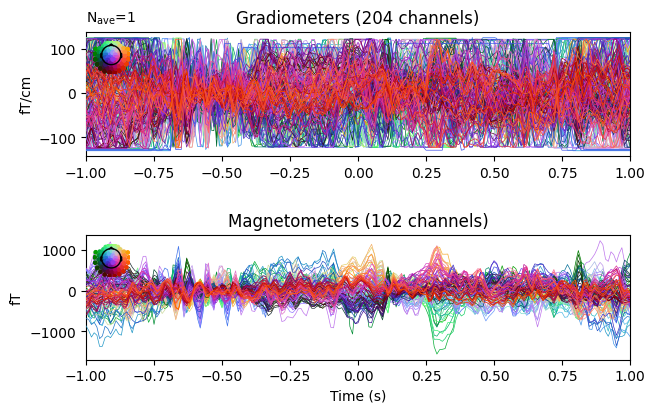

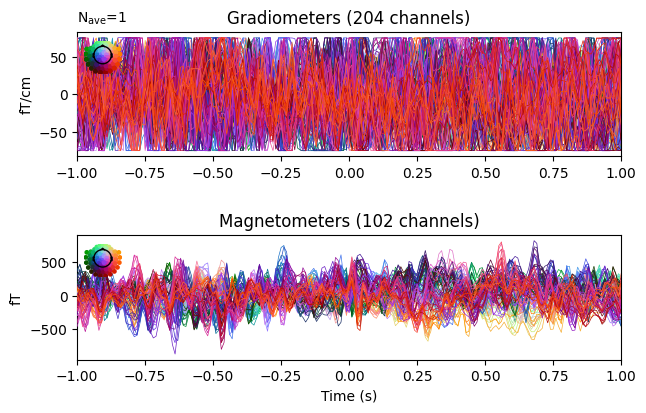

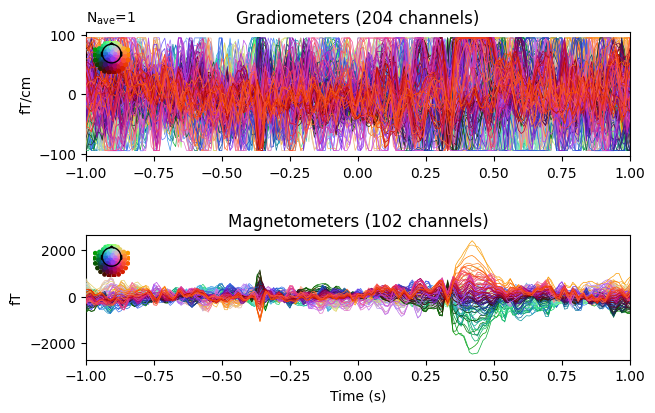

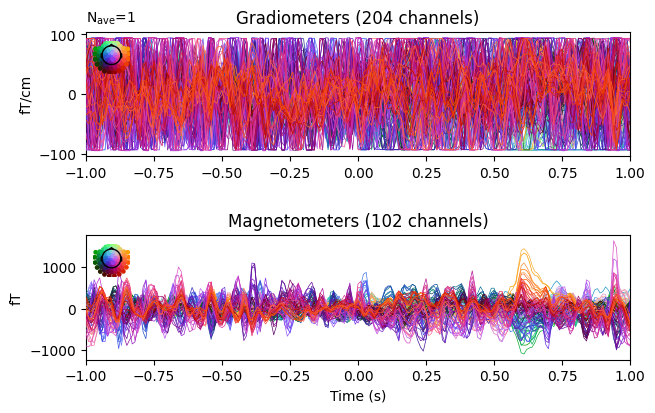

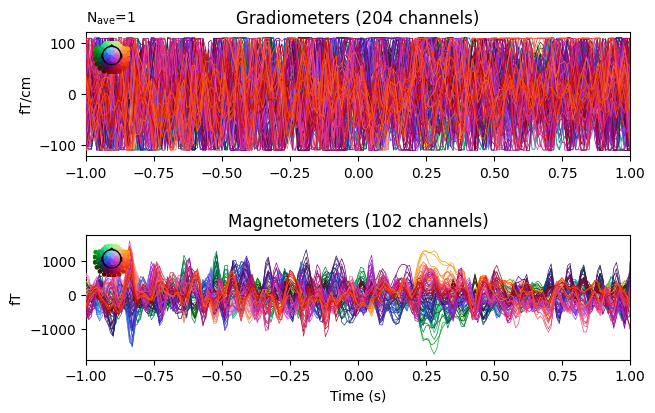

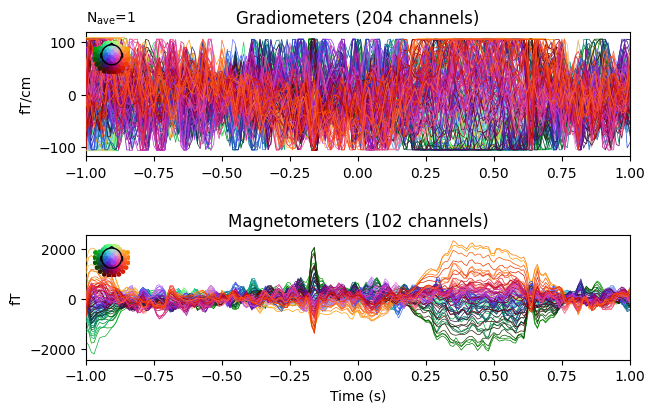

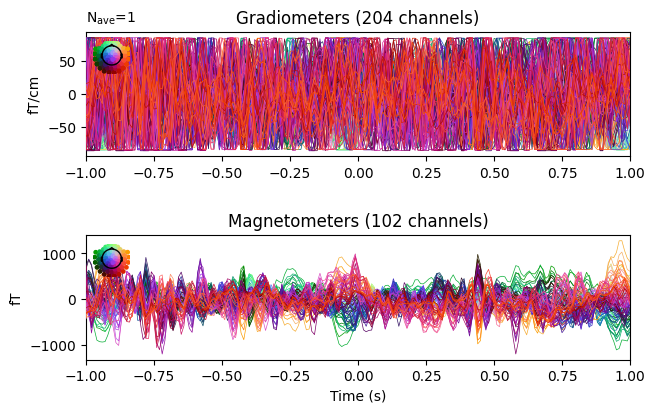

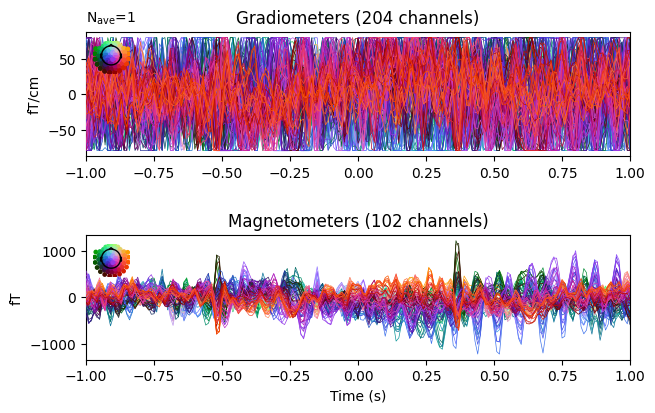

In [147]:
for subject in subjects:
    epochs ,raw, events = _get_epochs(subject)
    epochs.average(method='median').plot(spatial_colors=True, show=False)

In [115]:
print(events)

[[145050      1      1]
 [145420      1      1]
 [145530      1      1]
 ...
 [751870      1      1]
 [752040      1      1]
 [752200      1      1]]


In [116]:
normal_length = 607.181

diff_triggers = (events[-1][0] - events[0][0])/1000

print(diff_triggers)

print(f'Difference between length from .wav and in the tsv events is {1000*abs(normal_length-diff_triggers)} ms')

607.15
Difference between length from .wav and in the tsv events is 31.000000000062755 ms


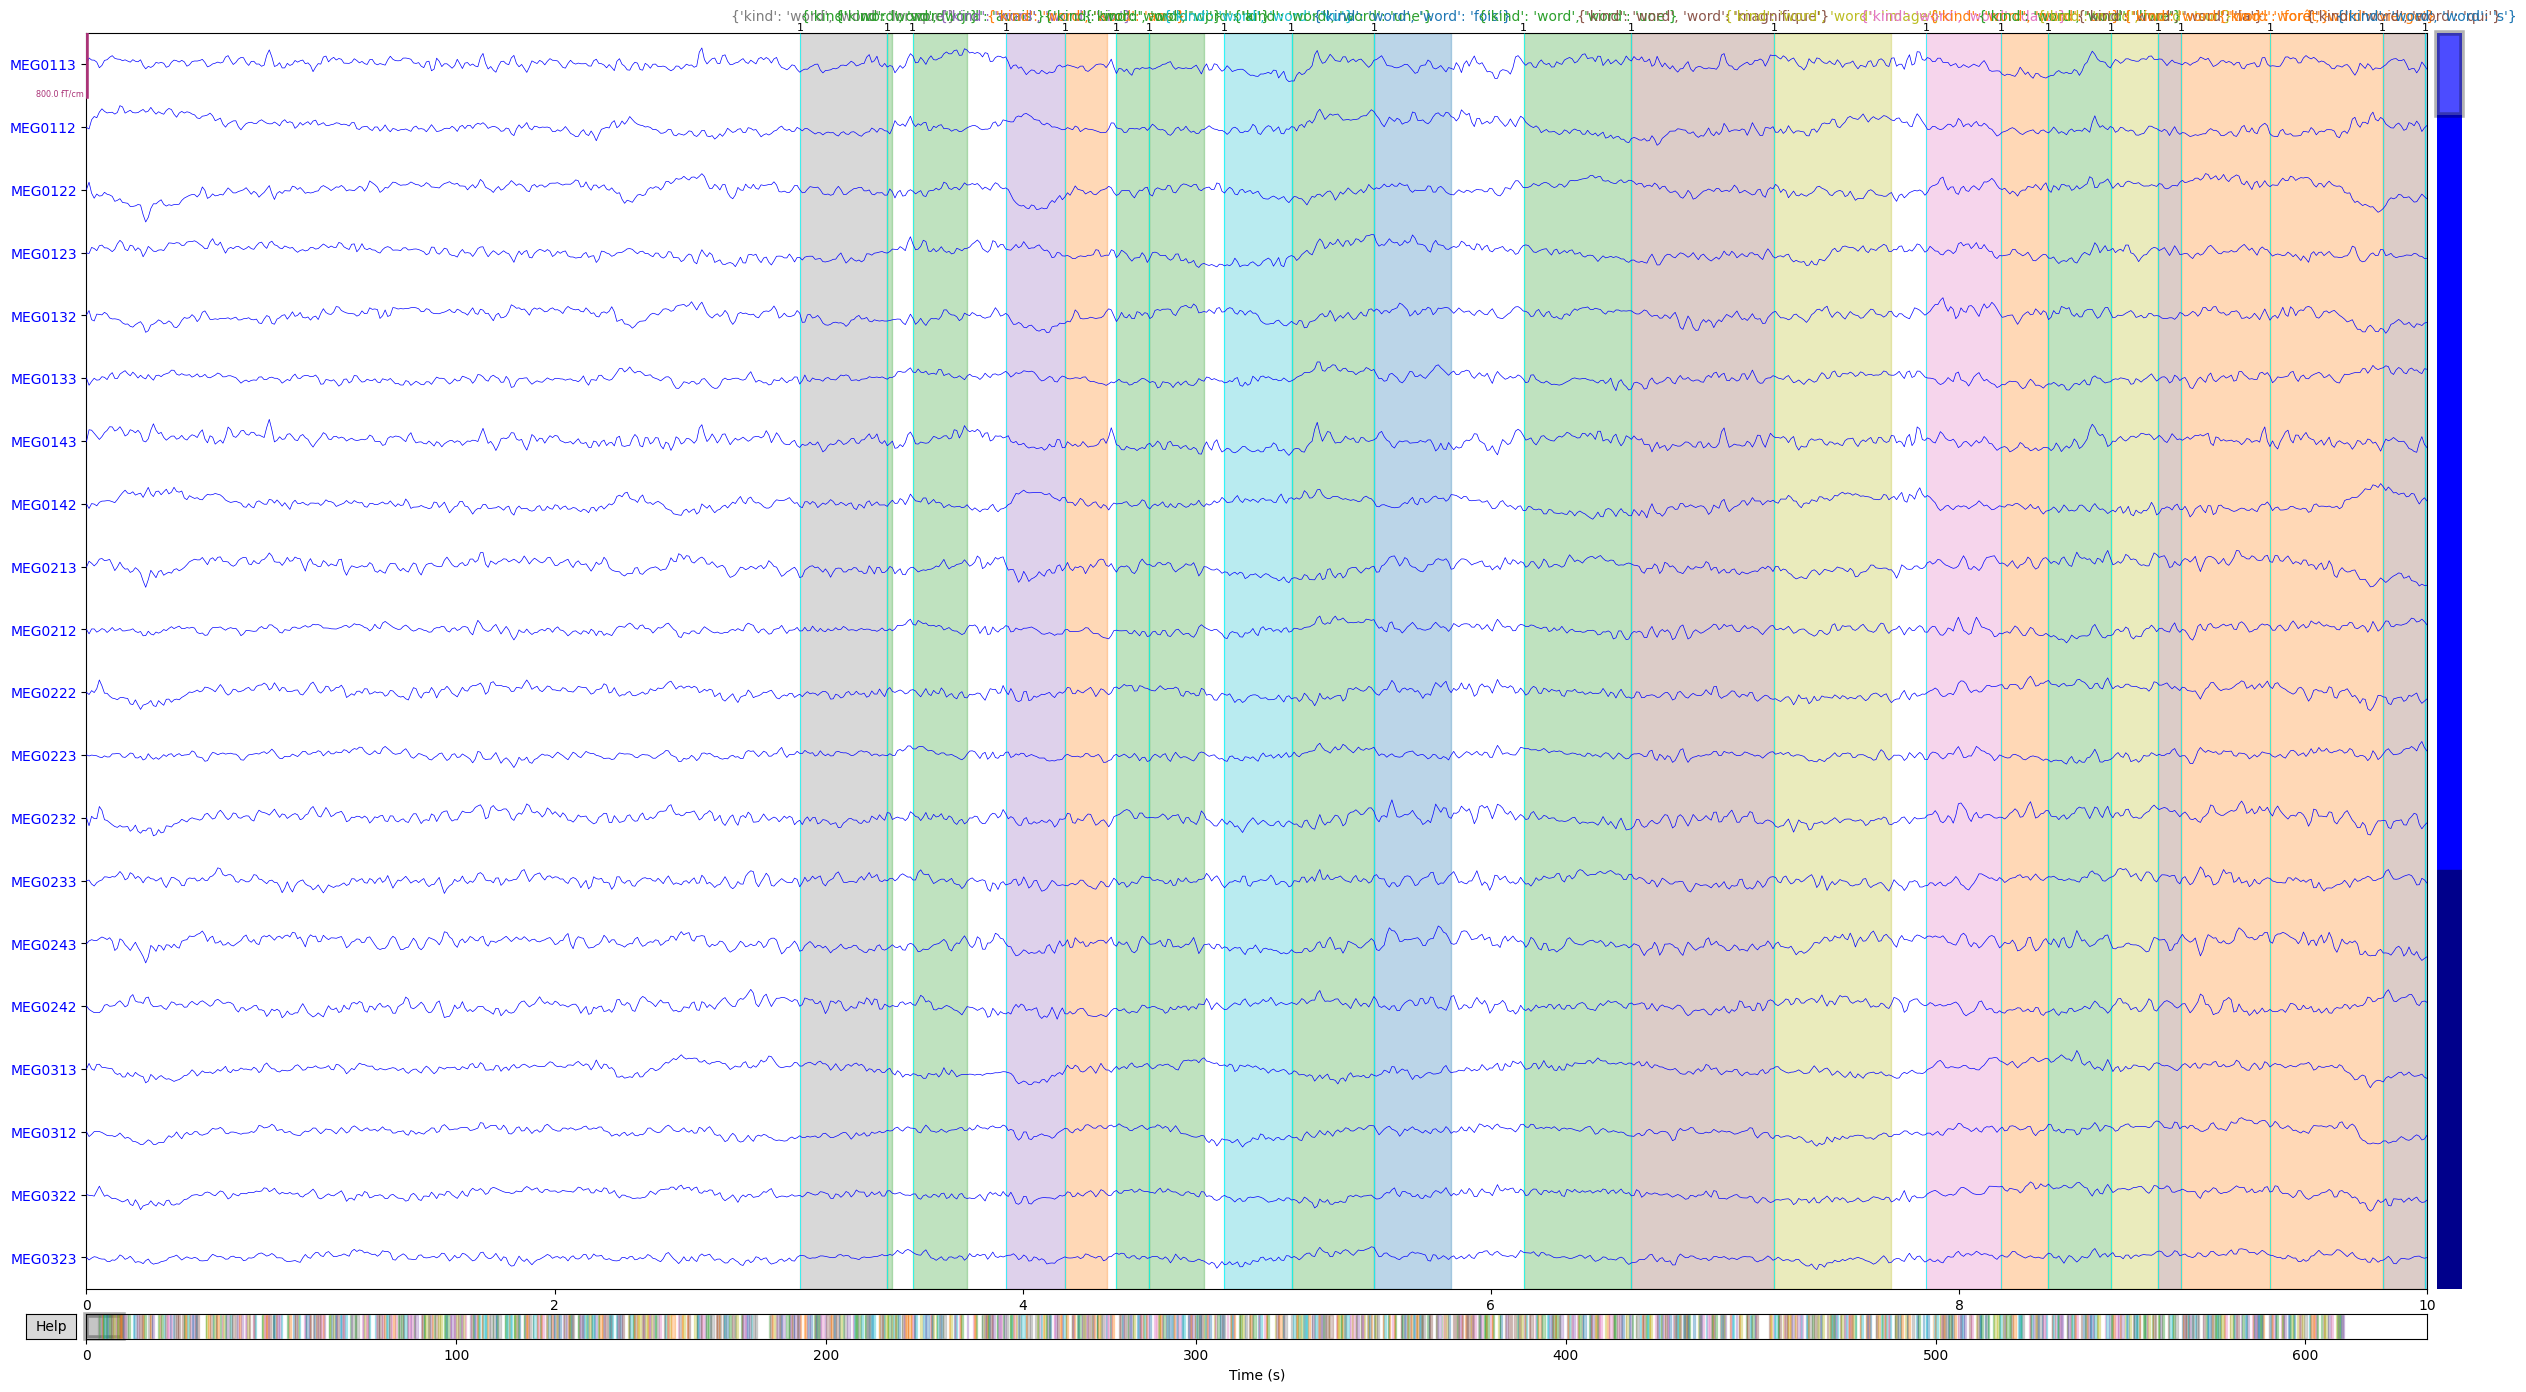

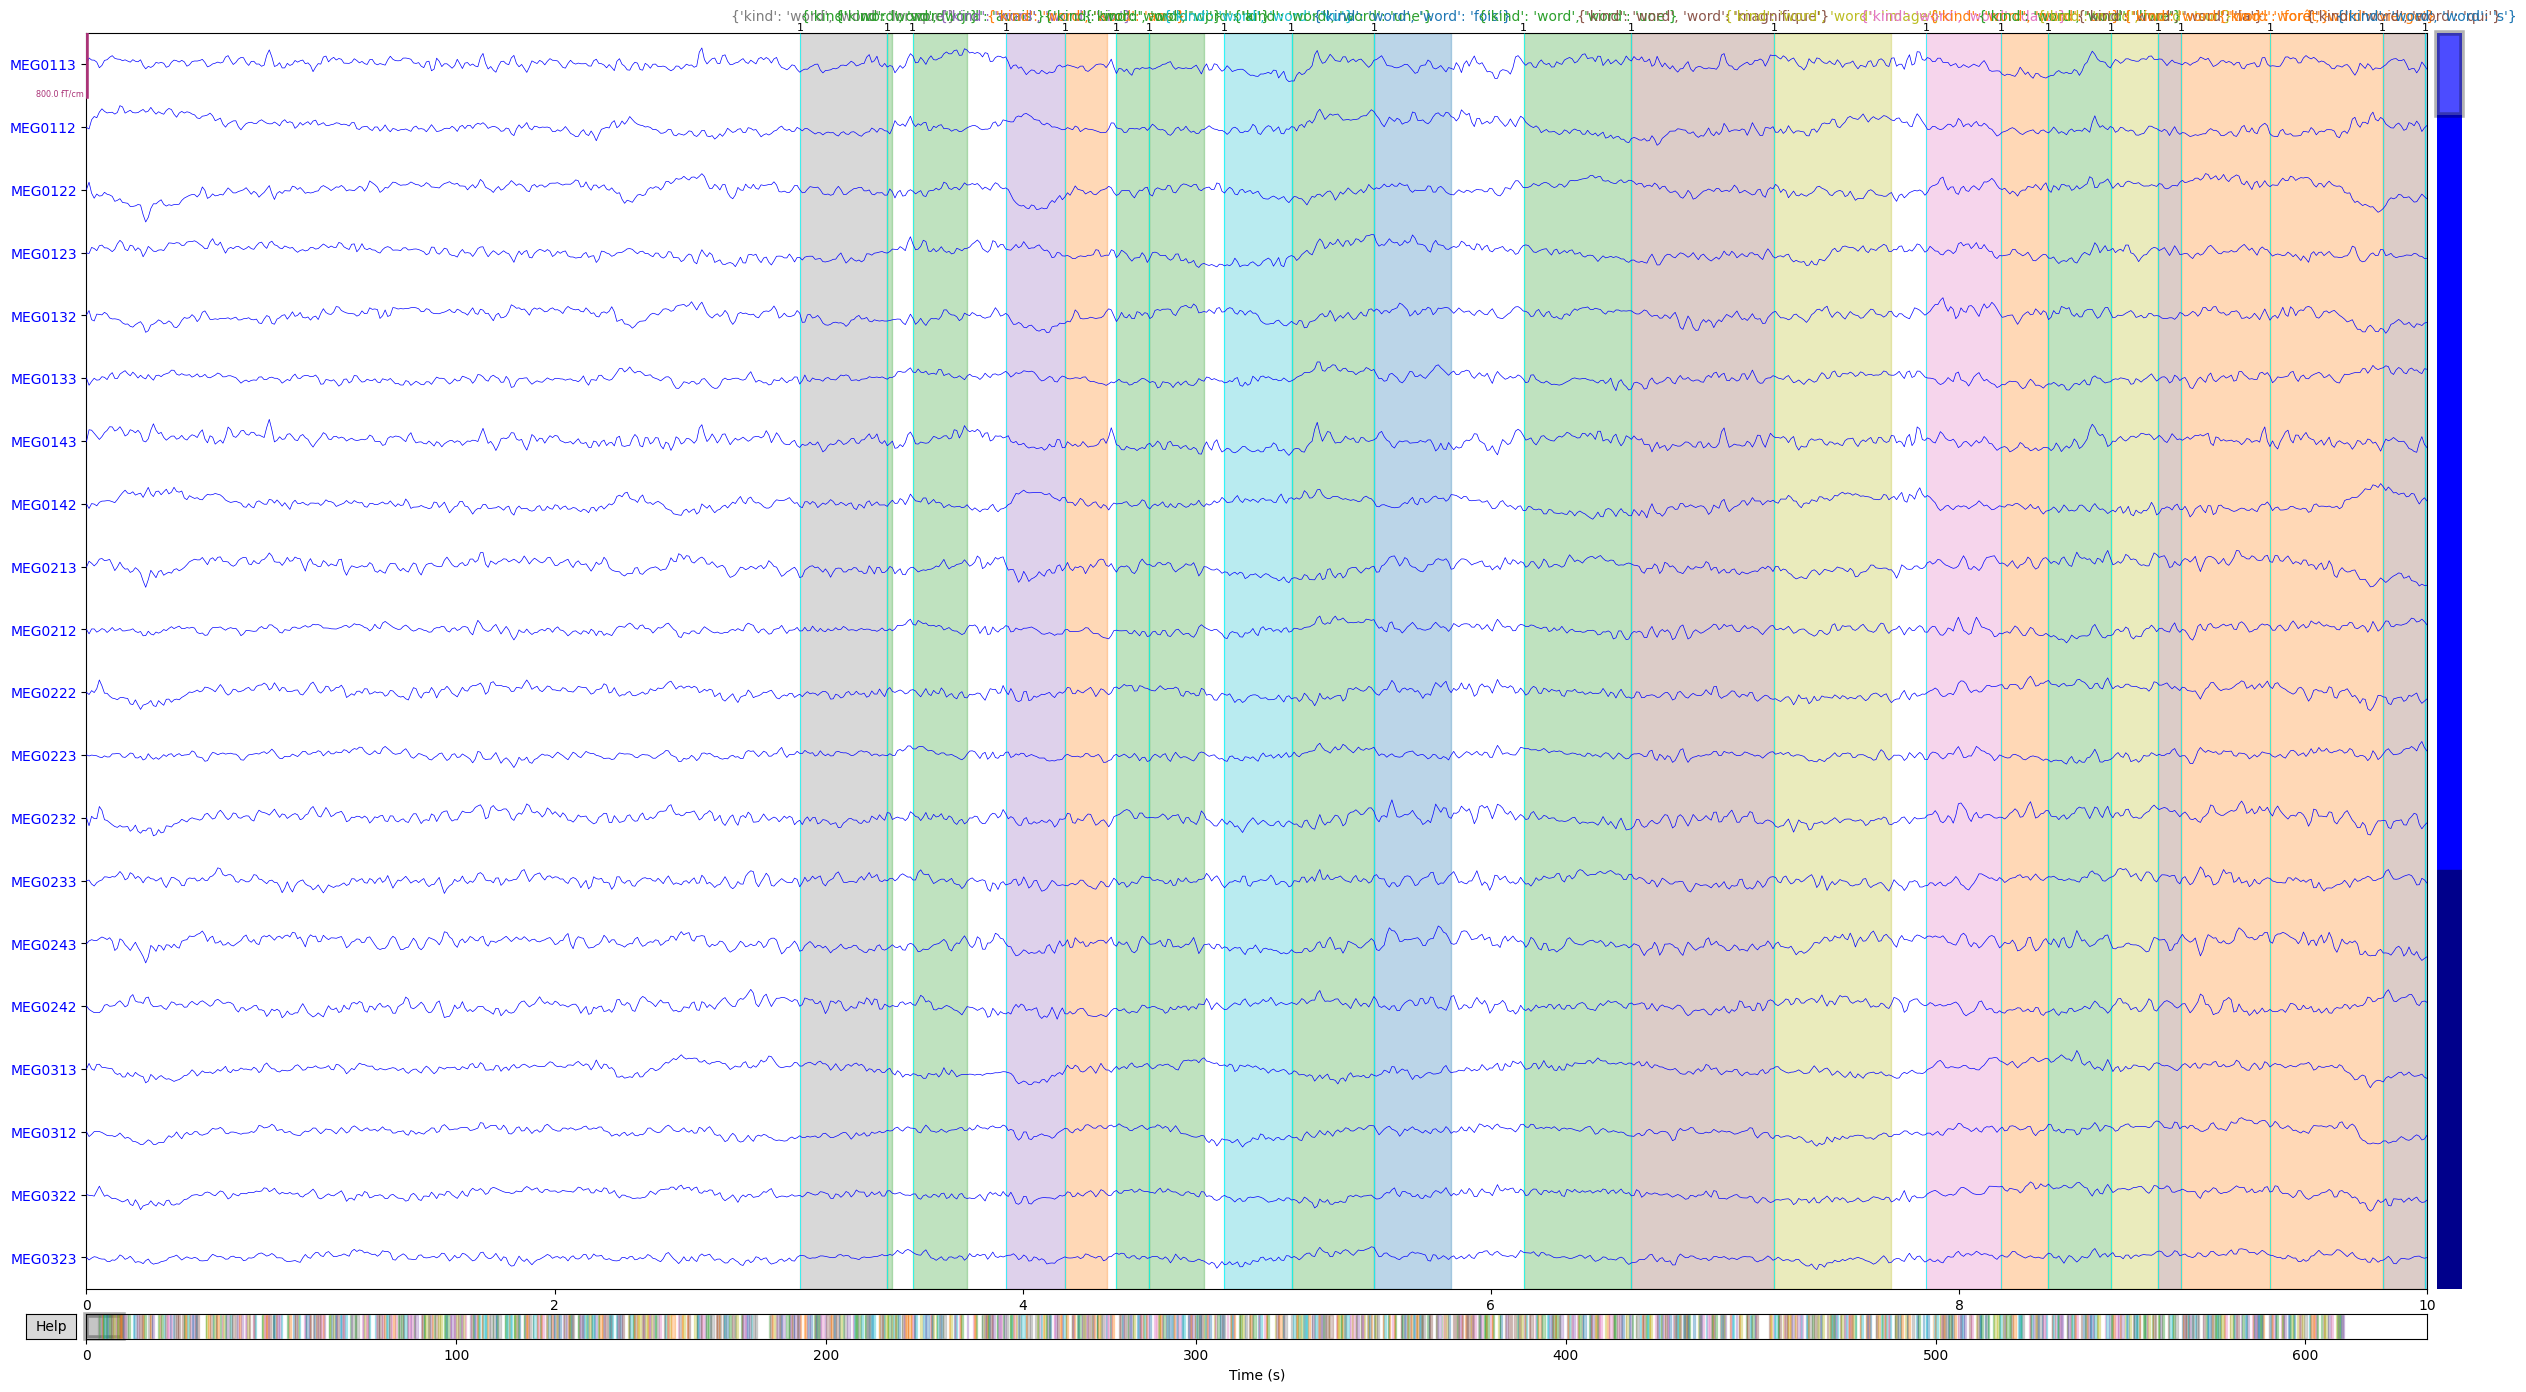

In [42]:
raw.plot(block=True,events=events)

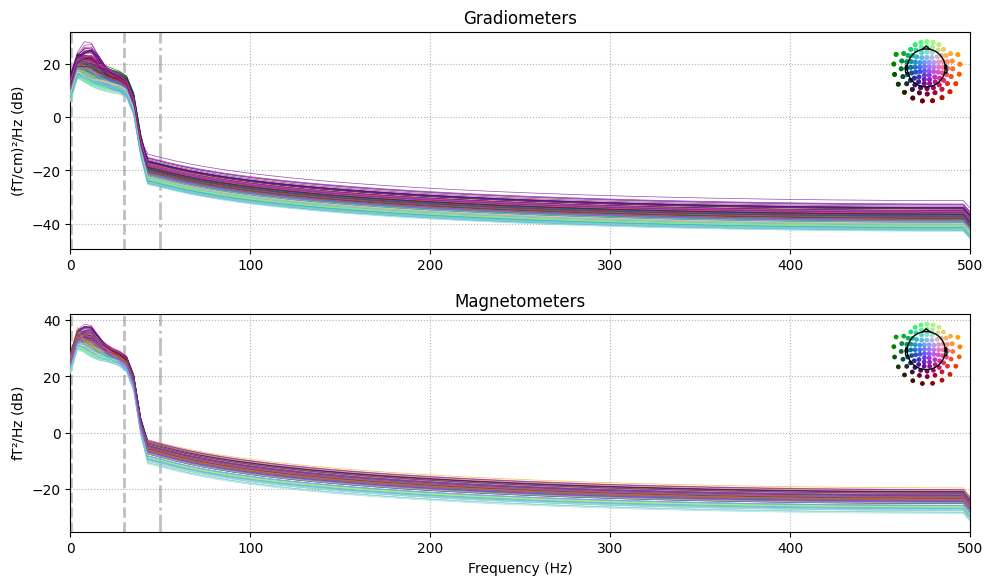

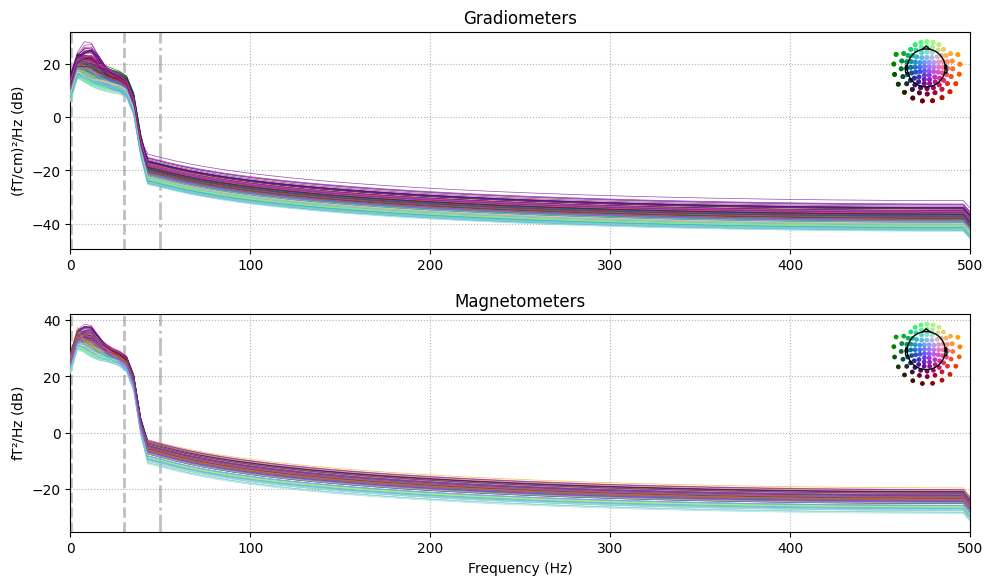

In [43]:
raw.plot_psd()

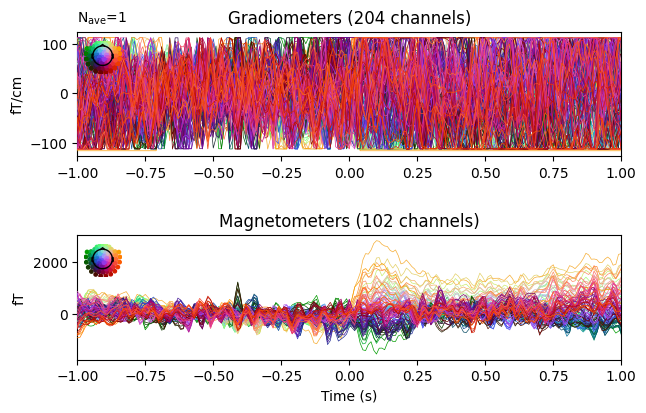

In [53]:
evo = epochs[3].average(method='median')
fig_evo = evo.plot(spatial_colors=True, show=False)


In [65]:
print(events[:,0]/raw.info['sfreq'])

[145.05 145.42 145.53 ... 751.87 752.04 752.2 ]


In [70]:
raw.annotations[0]

OrderedDict([('onset', 145.05),
             ('duration', 0.3700000000000001),
             ('description', "{'kind': 'word', 'word': 'lorsque'}"),
             ('orig_time',
              datetime.datetime(2022, 7, 7, 11, 58, 52, 907010, tzinfo=datetime.timezone.utc))])

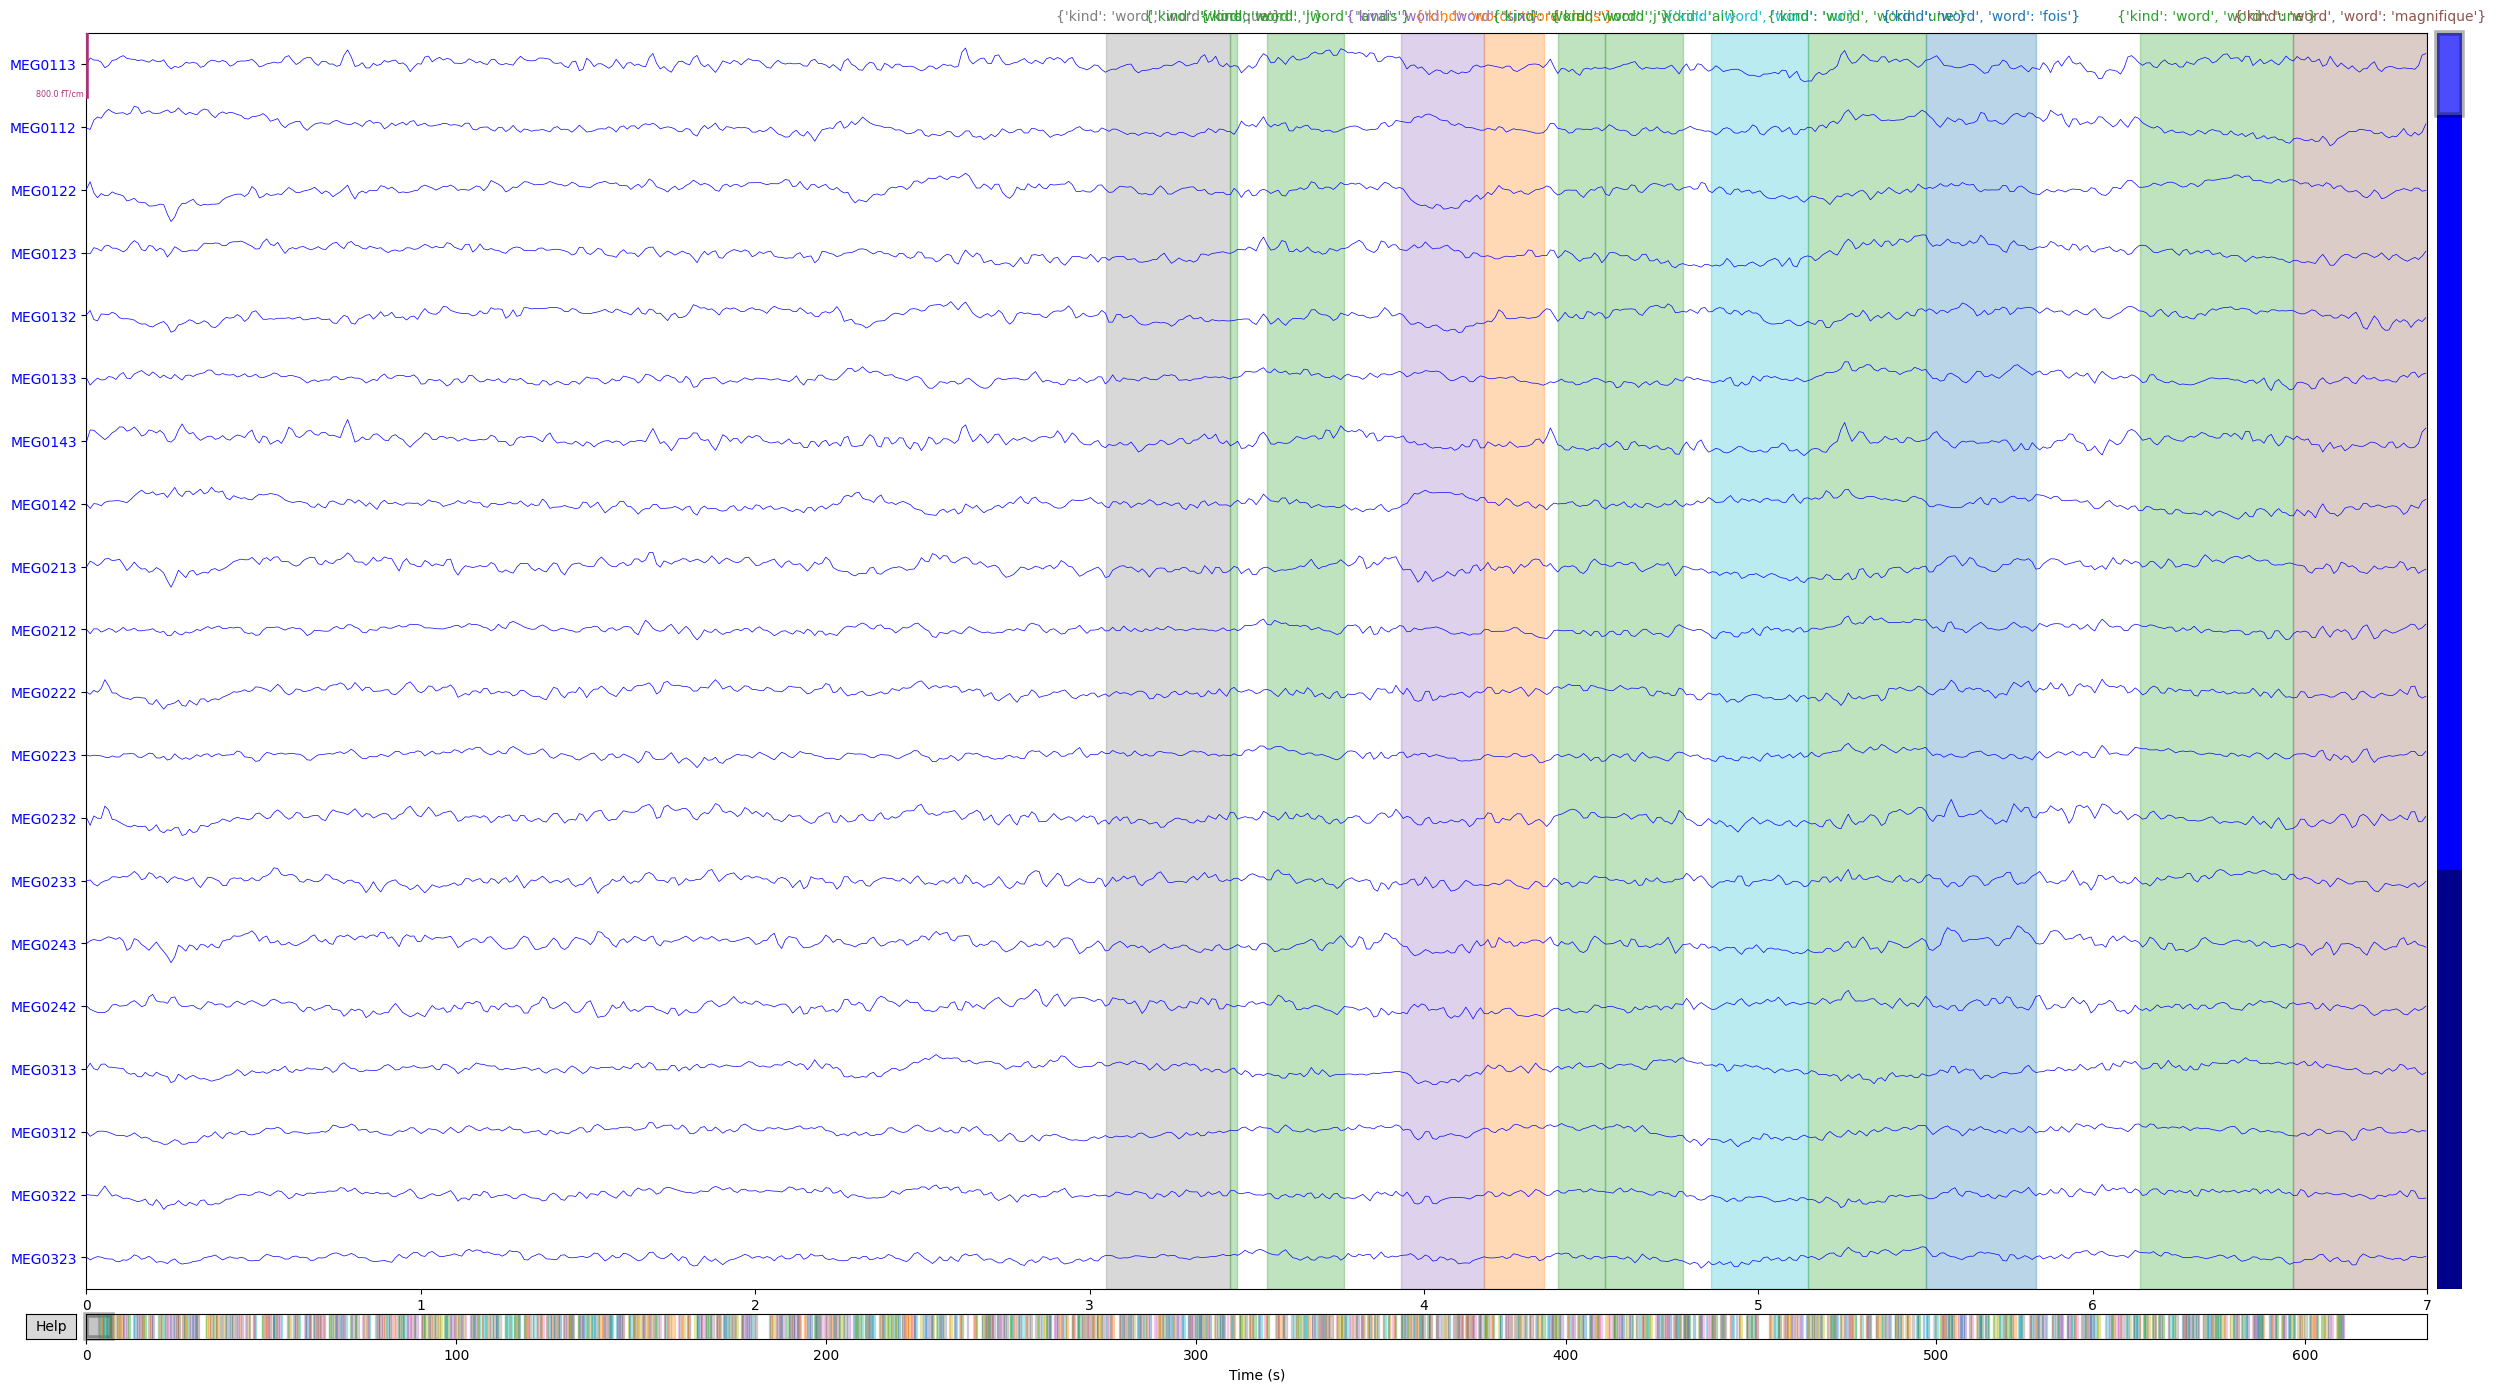

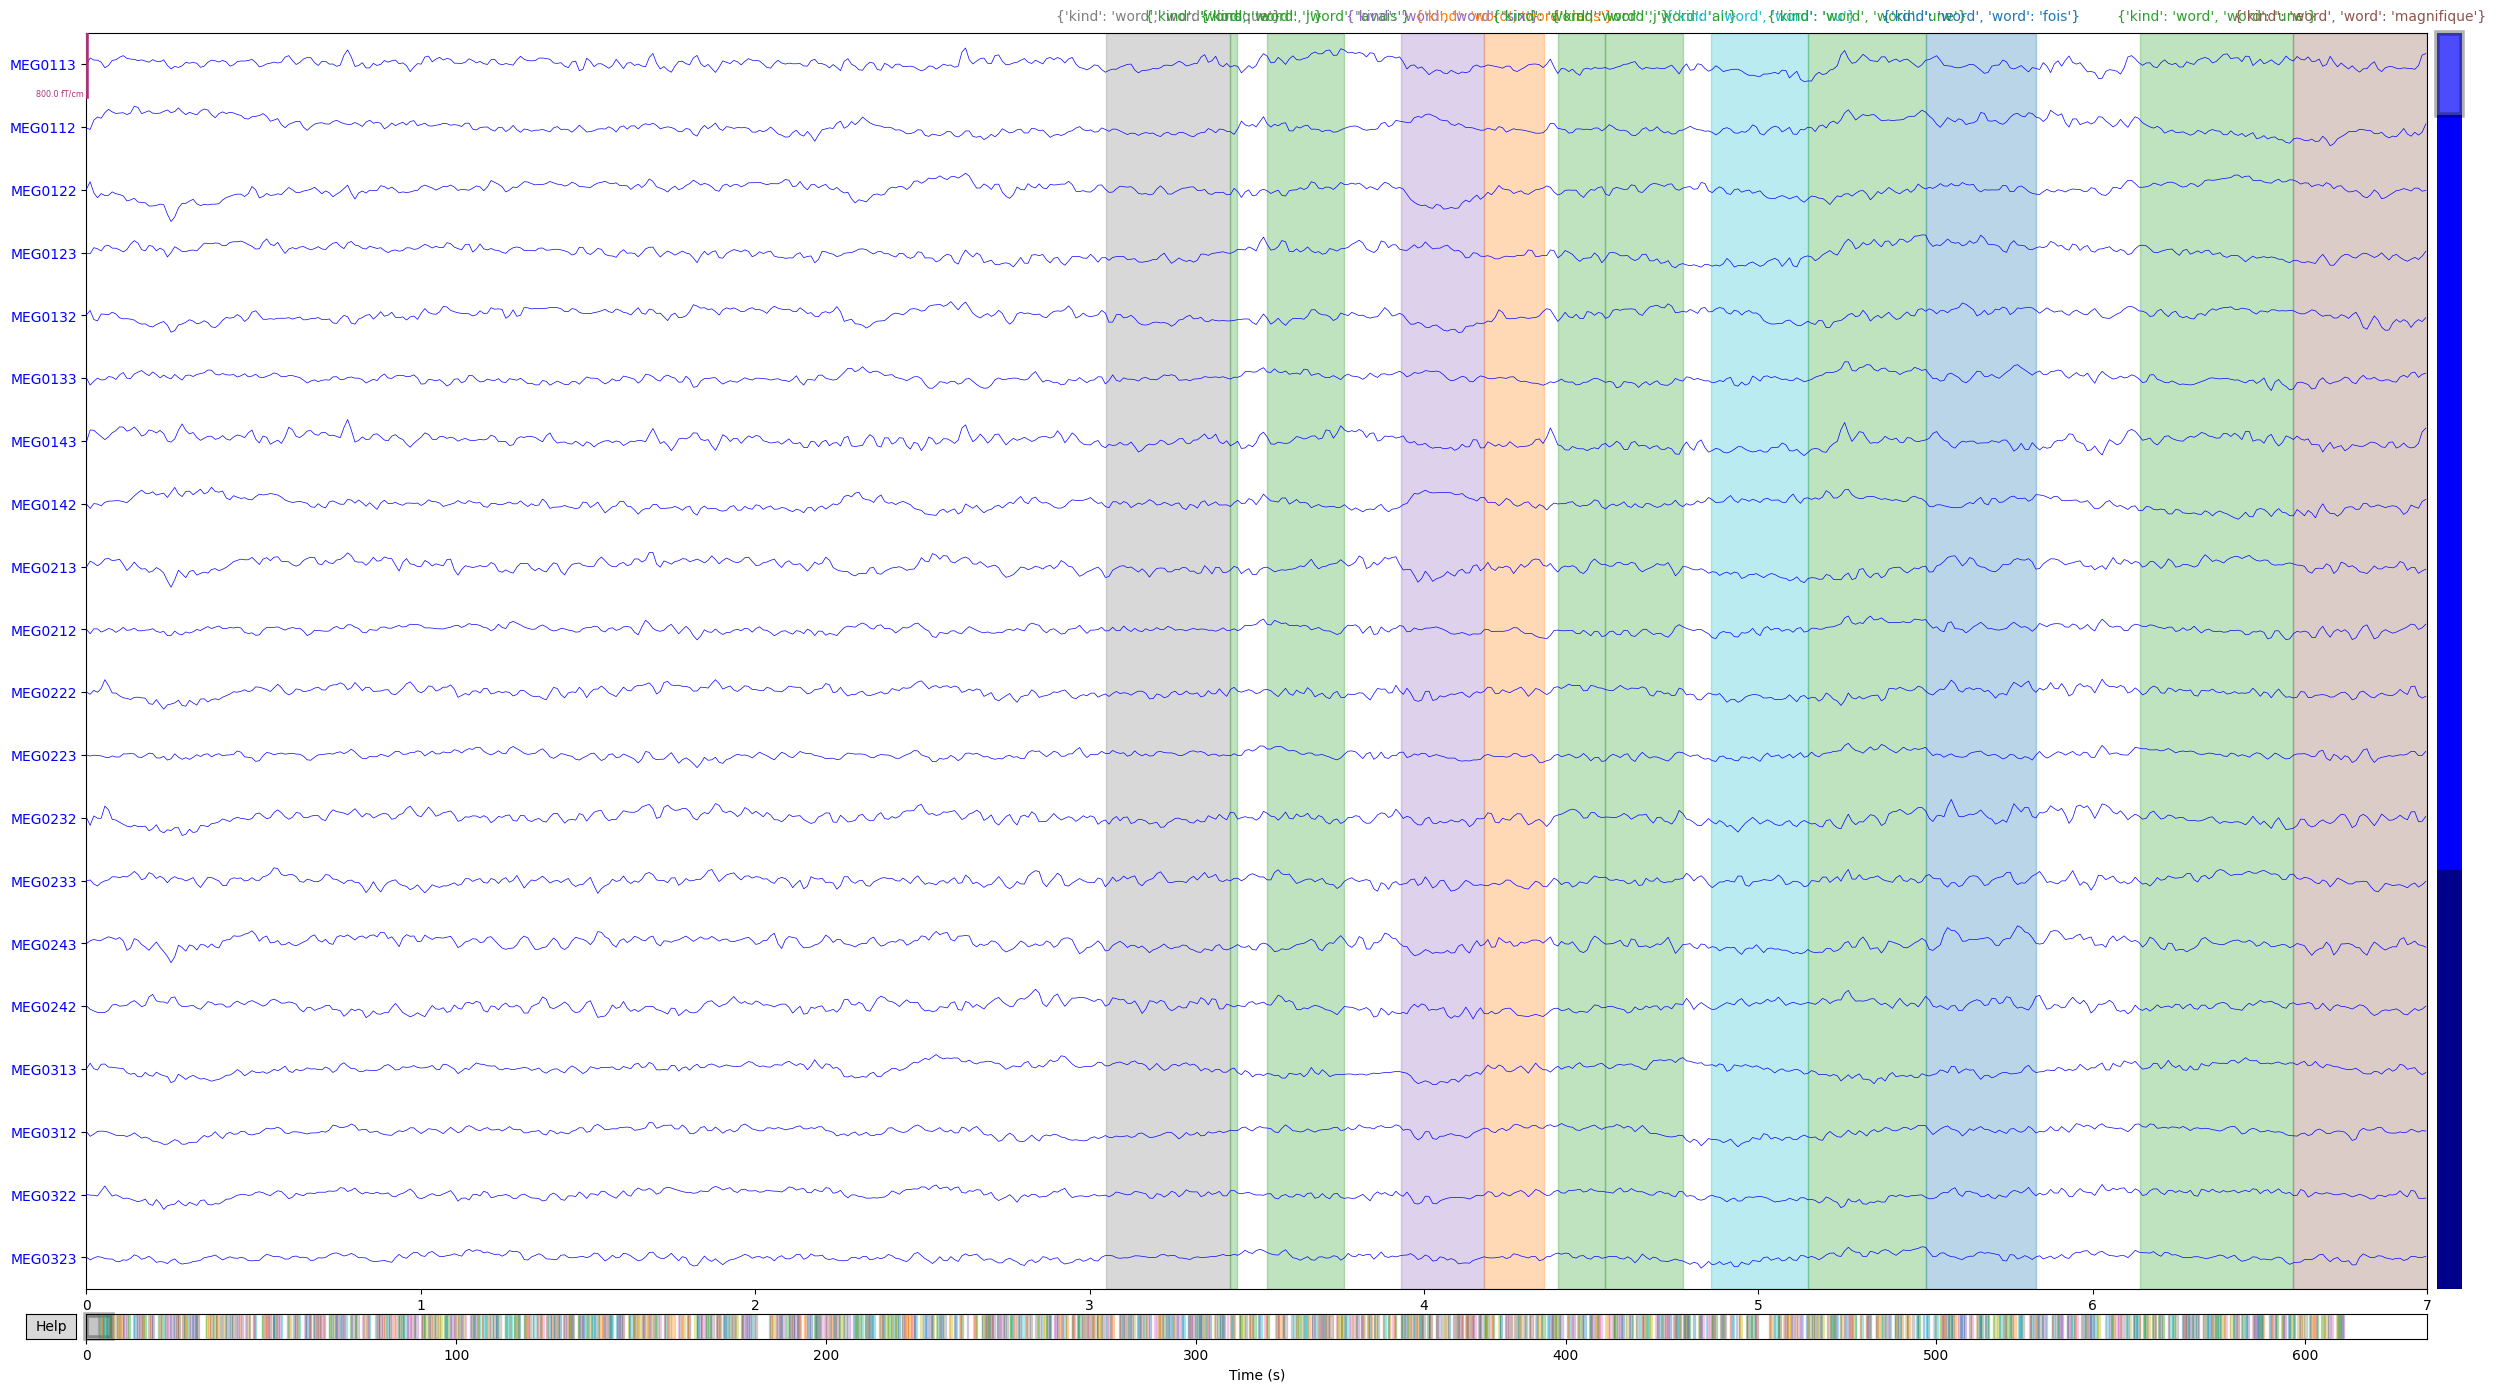

In [60]:

raw.plot(start=0, duration = 7)

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2